In [4]:
# quantify the distance between different generated datasets
import pandas as pd
import numpy as np

In [7]:
from thesislib.utils.ml import models

In [8]:
num_symptoms = 376

In [9]:
sparsifier = models.ThesisSymptomSparseMaker(num_symptoms=num_symptoms)

In [2]:
# want to get the condition counts
directories = [
    "output_basic_15k",
    "output_basic_pct_10_15k",
    "output_basic_pct_20_15k",
    "output_basic_pct_30_15k",
    "output_basic_pct_50_15k",
    "output_basic_pct_70_15k"
]

In [3]:
sparse_tpl = "/shares/bulk/oagba/data/{}/symptoms/csv/parsed/train.csv_sparse.csv"

In [6]:
files = []
for item in directories:
    filename = sparse_tpl.format(item)
    files.append(filename)

In [5]:
data = []

In [10]:
for file in files:
    df = pd.read_csv(file, index_col='Index')
    grp = df.groupby('LABEL')
    symptom_pct = np.zeros((801, 376))
    for idx in range(801):
        df_idx = grp.get_group(idx)
        df_idx = df_idx[['AGE', 'GENDER', 'RACE', 'SYMPTOMS']]
        df_idx = sparsifier.fit_transform(df_idx)
        # we just want the symptoms
        df_idx = df_idx[:, 3:]
        # now get the mean
        symptom_pct[idx, :] = np.mean(df_idx, axis=0)
    data.append(symptom_pct)

/shares/bulk/oagba/work/medvice-parser/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/shares/bulk/oagba/work/medvice-parser/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/shares/bulk/oagba/work/medvice-parser/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/shares/bulk/oagba/work/medvice-parser/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/shares/bulk/oag

In [51]:
from scipy.stats import wasserstein_distance, entropy

In [12]:
distance = np.zeros((801, len(data) -1))

In [52]:
kl_div = np.zeros((801, len(data) -1))

In [14]:
base_data = data[0]

In [20]:
indicies = []
for idx in range(801):
    indicies.append(np.where(base_data[idx] > 0)[0])

In [26]:
for idx in range(801):
    base_value = base_data[idx][indicies[idx]]
    for jdx in range(len(data) - 1):
        pct_value = data[jdx+1][idx][indicies[idx]]
        dist = wasserstein_distance(base_value, pct_value)
        distance[idx, jdx] = dist

In [53]:
for idx in range(801):
    base_value = base_data[idx][indicies[idx]]
    for jdx in range(len(data) - 1):
        pct_value = data[jdx+1][idx][indicies[idx]]
        dist = entropy(base_value, pct_value)
        kl_div[idx, jdx] = dist

In [29]:
avg = np.mean(distance, axis=0)
std = np.std(distance, axis=0)

In [33]:
import matplotlib.pyplot as plt

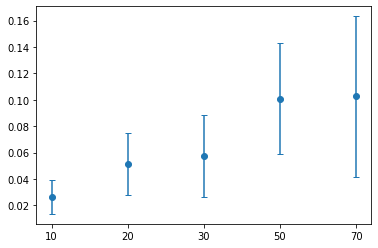

In [49]:
fig, ax = plt.subplots()
ax.errorbar(range(5), avg, std, marker='o', linestyle='None', capsize=3)
_ = ax.set_xticks(ticks=range(5))
_ = ax.set_xticklabels([10, 20, 30, 50, 70])

In [54]:
avg_kl = np.mean(kl_div, axis=0)
std_kl = np.std(kl_div, axis=0)

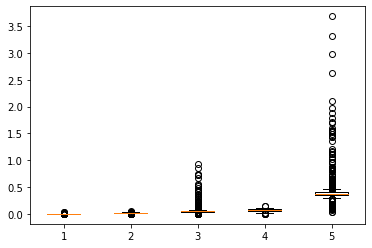

In [129]:
_ = plt.boxplot(kl_div)

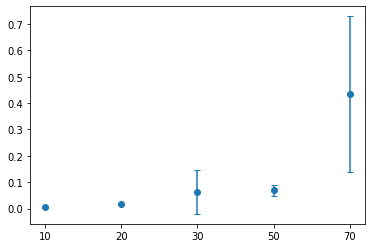

In [55]:
fig, ax = plt.subplots()
ax.errorbar(range(5), avg_kl, std_kl, marker='o', linestyle='None', capsize=3)
_ = ax.set_xticks(ticks=range(5))
_ = ax.set_xticklabels([10, 20, 30, 50, 70])

In [50]:
# but 50% has higher accuracy scores than 70 despite being more similar to the baseline
# why ?
# let's look at the confusion matrix and see what's in there, where does 50 do better than 70 with reference to the baseline
# then we'll take a look at those conditions 

In [59]:
cnf_50 = "/home/oagba/bulk/data/output_basic_pct_50_15k/symptoms/csv/parsed/learning/nb/naive_bayes_confusion_matrix.joblib"
cnf_70 = "/home/oagba/bulk/data/output_basic_pct_70_15k/symptoms/csv/parsed/learning/nb/naive_bayes_confusion_matrix.joblib"
cnf = "/home/oagba/bulk/data/output_basic_15k/symptoms/csv/parsed/learning/nb/naive_bayes_confusion_matrix.joblib"

In [57]:
import joblib

In [60]:
cnf = joblib.load(cnf)
cnf_50 = joblib.load(cnf_50)
cnf_70 = joblib.load(cnf_70)

In [63]:
base_correct = np.diag(cnf)
pct50_correct = np.diag(cnf_50)
pct70_correct = np.diag(cnf_70)

In [64]:
base_all = np.sum(cnf, axis=1)
pct50_all = np.sum(cnf_50, axis=1)
pct70_all = np.sum(cnf_70, axis=1)

In [69]:
base_acc = base_correct/base_all
pct50_acc = pct50_correct/pct50_all
pct70_acc = pct70_correct/pct70_all

In [73]:
diff50 = pct50_acc - base_acc
diff70 = pct70_acc - base_acc

In [76]:
imp50 = np.where(diff50 > 0)[0]

In [77]:
imp70 = np.where(diff70 > 0)[0]

In [81]:
imp_comb = np.intersect1d(imp50, imp70, assume_unique=True)

In [85]:
imp_50_better = np.setdiff1d(imp50, imp70, assume_unique=True)

In [187]:
imp_70_better = np.setdiff1d(imp70, imp50, assume_unique=True)

In [89]:
_50_distance = distance[imp_50_better, :]

In [91]:
_50_avg = np.mean(_50_distance, axis=0)
_50_std = np.mean(_50_distance, axis=0)

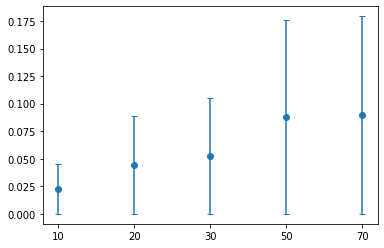

In [92]:
fig, ax = plt.subplots()
ax.errorbar(range(5), _50_avg, _50_std, marker='o', linestyle='None', capsize=3)
_ = ax.set_xticks(ticks=range(5))
_ = ax.set_xticklabels([10, 20, 30, 50, 70])

In [97]:
_50_pct_val = data[-2][imp_50_better, :]
_70_pct_val = data[-1][imp_50_better, :]

In [117]:
_50_max = np.max(_50_pct_val, axis=1)
_70_max = np.max(_70_pct_val, axis=1)

In [119]:
np.where(_50_max > _70_max)

(array([  0,   1,   2,   4,   6,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  33,  35,  36,  37,  38,  39,  40,  42,  43,  45,
         46,  47,  48,  49,  50,  51,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  91,  92,  93,  94,  95,  96,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 115, 116,
        117, 118, 119, 121, 122, 124, 125, 128, 129, 130, 131, 132, 133,
        134, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177,
        178, 180, 181, 182, 183, 184, 186, 187, 188, 189, 191, 192, 193,
        194, 196, 197, 198, 199, 200, 201, 202, 203

In [121]:
_diff = _50_max - _70_max

In [134]:
# check for num of symptoms higher than 50% probability
g_50 = np.zeros((801, len(data)))

In [157]:
for idx in range(801):
    for jdx in range(len(data)):
        pct_value = data[jdx][idx][indicies[idx]]
        cnt = np.where(pct_value > 0.7)[0].shape[0]
        g_50[idx, jdx] = cnt

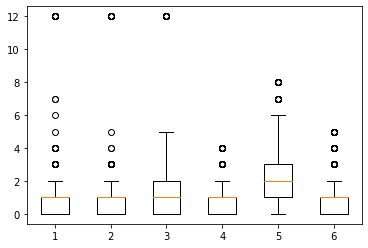

In [158]:
_ = plt.boxplot(g_50)

In [138]:
g_50_avg = np.mean(g_50, axis=0)
g_50_std = np.std(g_50, axis=0)

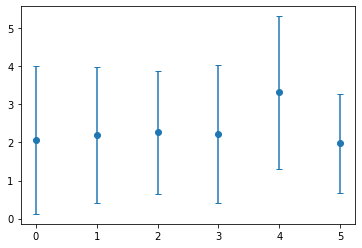

In [143]:
_ = plt.errorbar(range(6), g_50_avg, g_50_std, linestyle='None', marker='o', capsize=3)

In [201]:
# let's check the symptom distribution both in general and per condition
symptom_cnt = []
avg_cnt = []
for file in files:
    df_s_cnt = pd.read_csv(file, usecols=['Index', 'SYMPTOMS'])
    df_s_cnt['NUM_SYMPTOMS'] = df_s_cnt.SYMPTOMS.apply(lambda v: len(v.split(",")))
    symptom_cnt.append(df_s_cnt.groupby('NUM_SYMPTOMS').size())
    avg_cnt.append(df_s_cnt['NUM_SYMPTOMS'].mean())

In [203]:
avg_cnt

[3.3945673397137,
 3.3847146494761144,
 3.3622496006341143,
 3.203988443888249,
 4.104297339282646,
 2.7444261723822945]

In [146]:
plt_labels = ['base', '10', '20', '30', '50', '70']

In [241]:
fig_dir = "/home/oagba/bulk/data/reports/figures"

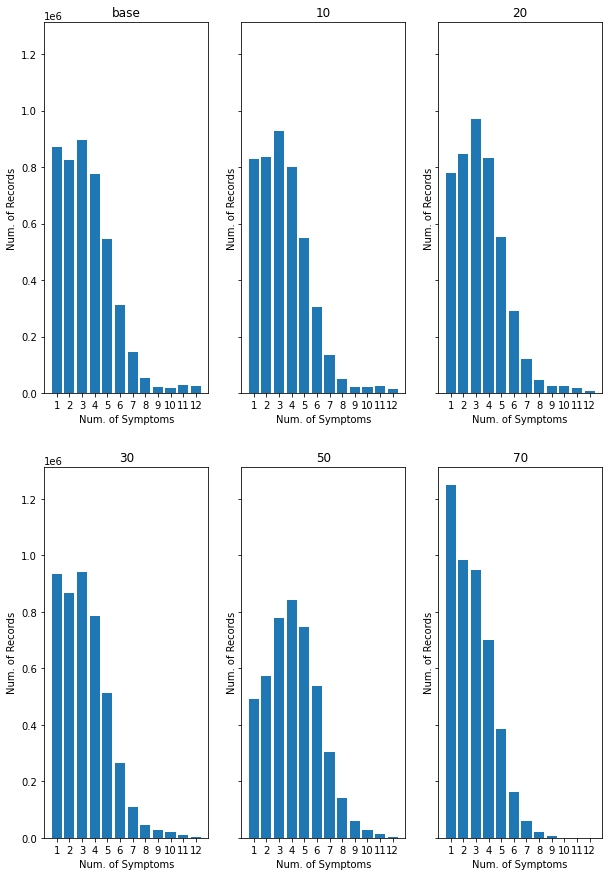

In [243]:
fig, axes = plt.subplots(2, 3, sharey=True)
for idx, lbl in enumerate(plt_labels):
    jdx = idx //3
    kdx = idx % 3
    cnt = symptom_cnt[idx]
    ax = axes[jdx, kdx]
    ax.bar(cnt.index, cnt)
    ax.set_title(lbl)
    ax.set_ylabel("Num. of Records")
    ax.set_xlabel("Num. of Symptoms")
    _ = ax.set_xticks(range(1, 13))

fig.set_size_inches(10, 15)

In [248]:
import os

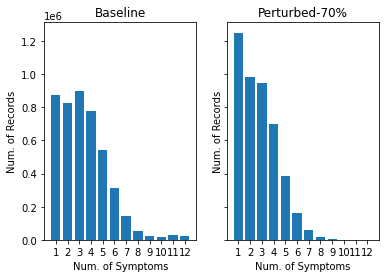

In [249]:
fig, axes = plt.subplots(1, 2, sharey=True)
for idx in range(2):
    if idx == 0:
        cnt_index = 0
        title = "Baseline"
    else:
        cnt_index = -1
        title = "Perturbed-70%"

    cnt = symptom_cnt[cnt_index]
    ax = axes[idx]
    ax.bar(cnt.index, cnt)
    ax.set_title(title)
    ax.set_ylabel("Num. of Records")
    ax.set_xlabel("Num. of Symptoms")
    _ = ax.set_xticks(range(1, 13))

fig.savefig(os.path.join(fig_dir, "baseline-70-symptom.png"))

In [238]:
symptom_cnt[-1].sum()

4516914

In [239]:
symptom_cnt[0].sum()

4517713

In [162]:
imp_50_better.shape

(256,)

In [169]:
# let's check the symptom distribution both in general and per condition
con_symptom_cnt = []
for file in files:
    df_s_cnt = pd.read_csv(file, usecols=['Index', 'SYMPTOMS', 'LABEL'])
    df_s_cnt['NUM_SYMPTOMS'] = df_s_cnt.SYMPTOMS.apply(lambda v: len(v.split(",")))
    grp = df_s_cnt.groupby('LABEL').NUM_SYMPTOMS
    con_symptom_cnt.append(grp)

In [172]:
avg_con_symptom_cnt = []
for item in con_symptom_cnt:
    avg_con_symptom_cnt.append(item.mean())

In [176]:
avg_con_symptom_cnt[-2][imp_50_better]

LABEL
0      1.884682
13     1.742533
15     4.836179
17     4.533319
19     2.752495
         ...   
789    1.335053
791    2.804129
794    1.444806
796    4.167453
799    2.678068
Name: NUM_SYMPTOMS, Length: 256, dtype: float64

In [183]:
avg_data = np.zeros((imp_50_better.shape[0], 3))

In [184]:
avg_data[:, 0] = avg_con_symptom_cnt[0][imp_50_better]
avg_data[:, 1] = avg_con_symptom_cnt[4][imp_50_better]
avg_data[:, 2] = avg_con_symptom_cnt[5][imp_50_better]

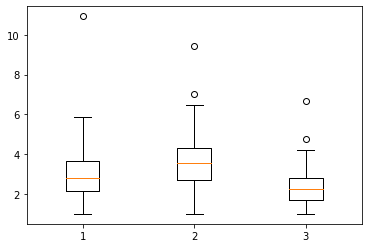

In [186]:
_ = plt.boxplot(avg_data)

In [188]:
imp_70_better.shape

(19,)

In [189]:
diff5070 = pct50_acc - pct70_acc

In [193]:
imp_50_cmp_diff = np.where(diff5070 > 0)[0]

In [194]:
imp_70_cmp_diff = np.where(diff5070 < 0)[0]

In [198]:
.shape

(196,)

In [195]:
imp_50_cmp_diff.shape

(605,)

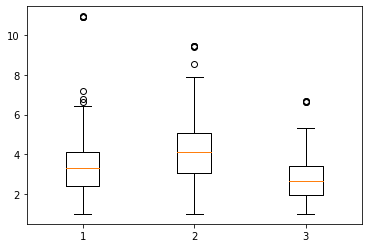

In [200]:
avg_data_ff = np.zeros((imp_50_cmp_diff.shape[0], 3))

avg_data_ff[:, 0] = avg_con_symptom_cnt[0][imp_50_cmp_diff]
avg_data_ff[:, 1] = avg_con_symptom_cnt[4][imp_50_cmp_diff]
avg_data_ff[:, 2] = avg_con_symptom_cnt[5][imp_50_cmp_diff]

_ = plt.boxplot(avg_data_ff)

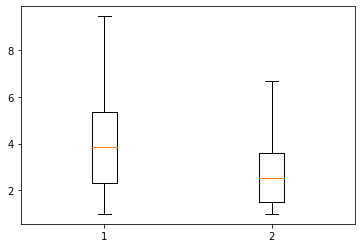

In [199]:
avg_data_ff1 = np.zeros((imp_70_cmp_diff.shape[0], 2))

avg_data_ff1[:, 0] = avg_con_symptom_cnt[4][imp_70_cmp_diff]
avg_data_ff1[:, 1] = avg_con_symptom_cnt[5][imp_70_cmp_diff]

_ = plt.boxplot(avg_data_ff1)

In [205]:
_70_base = np.where(diff70 > 0)[0]

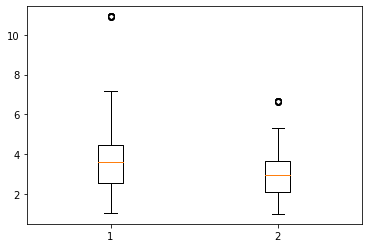

In [207]:
avg_data_70_base = np.zeros((_70_base.shape[0], 2))

avg_data_70_base[:, 0] = avg_con_symptom_cnt[0][_70_base]
avg_data_70_base[:, 1] = avg_con_symptom_cnt[5][_70_base]

_ = plt.boxplot(avg_data_70_base)

In [214]:
_0_pct = data[0]
_70_pct = data[-1]

In [217]:
_0_pct_70_better = _0_pct[_70_base, :]
_70_pct_70_better = _70_pct[_70_base, :]

In [222]:
max_symp_plot = np.zeros((_0_pct_70_better.shape[0], 2))
max_symp_plot[:, 0] = np.max(_0_pct_70_better, axis=1)
max_symp_plot[:, 1] = np.max(_70_pct_70_better, axis=1)

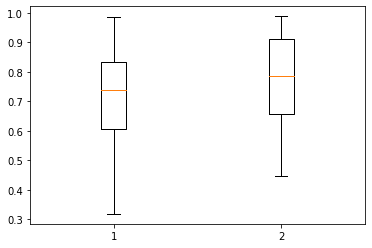

In [224]:
_ = plt.boxplot(max_symp_plot)

In [225]:
_0_base = np.where(diff70 < 0)[0]

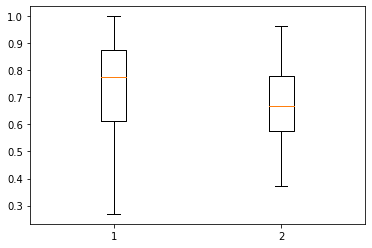

In [226]:
_0_pct_0_better = _0_pct[_0_base, :]
_70_pct_0_better = _70_pct[_0_base, :]
max_symp_plot = np.zeros((_0_pct_0_better.shape[0], 2))
max_symp_plot[:, 0] = np.max(_0_pct_0_better, axis=1)
max_symp_plot[:, 1] = np.max(_70_pct_0_better, axis=1)
_ = plt.boxplot(max_symp_plot)

In [236]:
max_symp_plot = np.zeros((801, 6))
for idx in range(len(data)):
    max_symp_plot[:, idx] = np.max(data[idx], axis=1) - np.min(data[idx], axis=1)

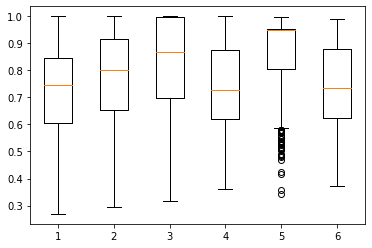

In [237]:
_ = plt.boxplot(max_symp_plot)

In [233]:
case_counts = []
for file in files:
    df = pd.read_csv(file, index_col='Index')
    case_counts.append(df.shape[0])

/shares/bulk/oagba/work/medvice-parser/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [234]:
case_counts

[4517713, 4514728, 4516535, 4516398, 4516376, 4516914]